# Анализ поведения пользователей мобильного приложения

# Описание проекта
Дизайнеры мобильного приложения в стартапе, который продает продукты питания, захотели поменять шрифты во всём приложении. Для нивелирования рисков того, что пользователям не понравится такое изменение, договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 

Цель - разобраться, как ведут себя пользователи мобильного приложения.  

Задачи:
1. изучить воронку продаж:  
  * узнать, как пользователи доходят до покупки; 
  * сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно;
2. иссследовать результаты A/A/B-эксперимента: выяснить, какой шрифт лучше.


# Описание данных  
Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка файла с данными и изучение общей информации
Путь к файлу: /datasets/logs_exp.csv. Скачать датасет

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go

In [2]:
# прочитаем файл и загрузим данные в переменную
logs = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
# посмотрим на первые 5 строк датафрейма
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#посмотрим общую информацию
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
logs.shape

(244126, 4)

В датафрейме 4 столбца, всего 244126 строк, пропуски отсутствуют  
Нужно привести названия столбцов к удобному виду и тип данных в столбце EventTimestamp к дате, а также проверить наличие дубликатов

## Предобработка данных

### Переименование столбцов

In [6]:
# переименуем столбцы
logs.rename(
    columns={
        'EventName':'event_name',
        'DeviceIDHash':'user_id',
        'EventTimestamp':'dt',
        'ExpId':'group'},
    inplace=True
)

In [7]:
# проверим корректность замены
logs.head()

,event_name,user_id,dt,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверка пропусков, дубликатов и типов данных

In [8]:
# проверим наличие пропусков
logs.isna().sum()

event_name    0
user_id       0
dt            0
group         0
dtype: int64

In [9]:
# проверим наличие дубликатов
logs.duplicated().sum()

413

In [10]:
# проверим, какую долю дубликаты составляют от общего числа
round(logs.duplicated().sum() / len(logs) * 100, 2)

0.17

В датафрейме 413 дубликатов, что составляет всего 0,17% от общего количества, поэтому спокойно можем удалить дубликаты

In [11]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [12]:
# проверим, что дубликаты удалены 
logs.duplicated().sum()

0

In [13]:
# заменим тип данных в столбце event_time
logs['dt'] = pd.to_datetime(logs['dt'], unit='s')

In [14]:
# проверим, что тип данных изменился
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   dt          243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


### Добавление столбца с датами

Столбец dt мы уже превратили в столбец даты и времени, добавим отдельный столбец только с датами

In [15]:
logs['date'] = pd.to_datetime(logs['dt']).dt.date.astype('datetime64')

In [16]:
# проверим, что все корректно отображается
logs.head()

,event_name,user_id,dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод по шагу 2:

Предобработка данных завершена:
* пропуски в данных отсутствуют;
* дубликаты составляют всего 0,17%, их удалили;
* наименования столбцов приведены к удобному виду;
* добавлен столбец с датой.

## Изучение и проверка данных

### Сколько всего событий в логе?

In [17]:
len(logs["event_name"])

243713

Всего в логе 243 713 события

### Сколько всего пользователей в логе?

In [18]:
logs['user_id'].nunique()

7551

В логе всего 7 551 пользователей

### Сколько в среднем событий приходится на пользователя?

In [19]:
logs.groupby('user_id')['event_name'].count().mean()

32.27559263673685

В среднем на пользователя приходится 32 события

In [20]:
logs.describe()

,user_id,group
count,2.437130e+05,243713.000000
mean,4.627963e+18,247.022161
std,2.642723e+18,0.824420
min,6.888747e+15,246.000000
25%,2.372212e+18,246.000000
50%,4.623192e+18,247.000000
75%,6.932517e+18,248.000000
max,9.222603e+18,248.000000


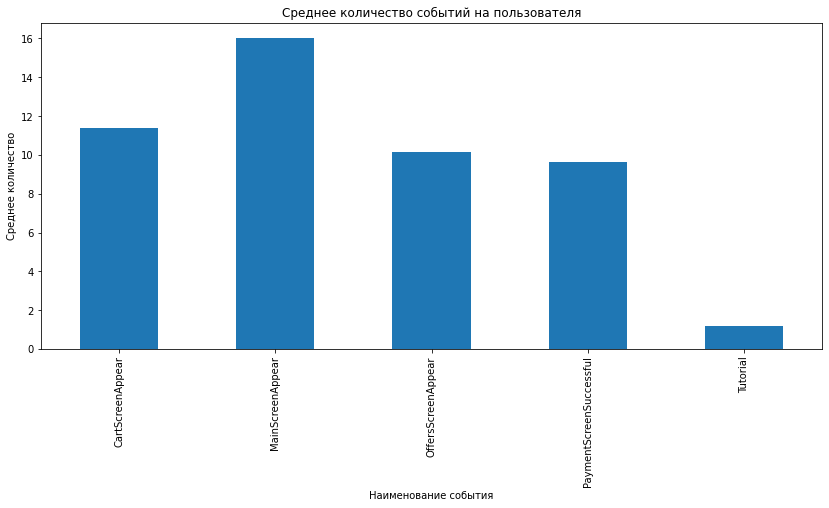

In [21]:
# построим гистограмму среднего количества событий на пользователя
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,6))
user_event = logs.groupby('event_name').agg({'group':'count','user_id':'nunique'})
user_event['mean_user']= user_event['group']/user_event['user_id']
user_event['mean_user'].plot(kind='bar', ax=ax)

ax.set_title('Среднее количество событий на пользователя')
ax.set_xlabel('Наименование события')
ax.set_ylabel('Среднее количество');

Самое большое среднее количество событий в MainScreenAppear - 16, меньше всего в Tutorail - 1  
Вероятно, обучение почти никто не проходит

### Проверка периода собранных данных
Необходимо ответить на следующие вопросы:
* Данными за какой период вы располагаете? Найдите максимальную и минимальную дату 
* Постройте гистограмму по дате и времени 
* Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
* Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [22]:
# найдем максимальную и минимальную дату
logs['date'].min(), logs['date'].max()

(Timestamp('2019-07-25 00:00:00'), Timestamp('2019-08-07 00:00:00'))

В датафрейме присутствуют данные с 25.07.2019 по 07.08.2019

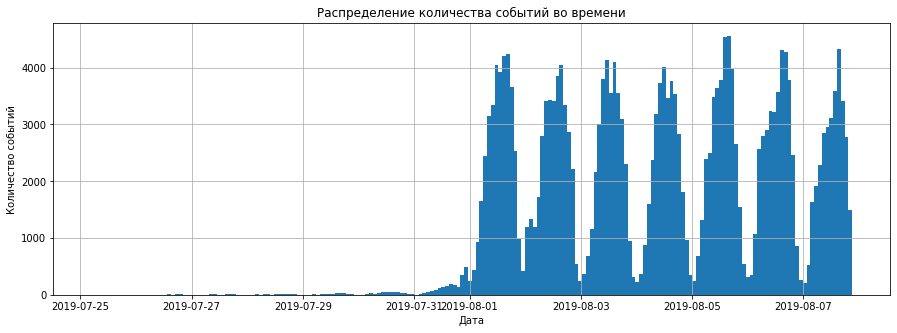

In [23]:
# построим гистограмму по дате и времени
logs['dt'].hist(figsize=(15,5), bins=200)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение количества событий во времени')
plt.show()

Судя по графику, у нас неодинаково полные данные за весь период, полные данные начинаются с 01.08.2019, т.е. правильно будет смотреть на данные с 01.08.2019 по 07.08.2019, а остальные можно отбросить

In [24]:
# соберем в новую переменную данные с 01.08.2019
data = logs.query('date >= "2019-08-01"')

In [25]:
# проверим, что остались только нужные данные
data['date'].min(), data['date'].max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2019-08-07 00:00:00'))

Стоит проверить, много ли событий и пользователей мы потеряли, отбросив старые данные

In [26]:
# проверим потери по количеству событий
print(f'Количество событий в логе до удаления: {len(logs["event_name"])}')
print(f'Количество событий в логе после удаления: {len(data["event_name"])}')
print('Потери составили: {0:.2%}'.format(((len(logs) - len(data)) / len(logs))))

Количество событий в логе до удаления: 243713
Количество событий в логе после удаления: 240887
Потери составили: 1.16%


In [27]:
# проверим потери по количеству пользователей
print(f'Количество пользователей в логе до удаления: {logs["user_id"].nunique()}')
print(f'Количество пользователей в логе после после удаления: {data["user_id"].nunique()}')
print('Потери составили: {0:.2%}'.format(((logs['user_id'].nunique() - data['user_id'].nunique()) / logs['user_id'].nunique())))

Количество пользователей в логе до удаления: 7551
Количество пользователей в логе после после удаления: 7534
Потери составили: 0.23%


Мы потеряли незначительное количество событий (1,16%) и пользователей (0,23%), соответственно, дальнейший анализ можем проводить на отфильтрованных данных

### Проверка корректности распределения пользователей по группам

In [28]:
# сгруппируем по группам
data.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Присутствуют пользователи из всех трех групп, и количество пользователей в группах практически не различается  
Также стоит проверить, не попали ли какие-то пользователи сразу в несколько групп

In [29]:
# проверим нет ли пересечений
data.groupby('user_id').agg({'group': 'nunique'}).query('group > 1').count()

group    0
dtype: int64

### Вывод по шагу 3: 
В отфильтрованных данных остались события за неделю с 01.08.2019 по 07.08.2019, потери событий и пользователей при этом составили 1,16% и 0,23% соответственно, что позволяет провести дальнейший анализ    
Пользователи присутствуют во всех трех группах практически в равном соотношении и не пересекаются

## Шаг 4. Изучение воронки событий

### Анализ распределения событий
Необходимо посмотреть, какие события есть в логах, как часто они встречаются и отсортировать события по частоте

In [30]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего 5 событий:  
1. Появление главной страницы
2. Появление страницы с предложением
3. Открытие корзины
4. Экран успешной оплаты
5. Туториал (инструкция или обучающий ролик)  

Чаще всего встречается появление главной страницы, а реже всего - туториал

### Расчет доли пользователей по событиям
В рамках данного пункта необходимо: 
* посчитать, сколько пользователей совершали каждое из событий 
* отсортировать события по числу пользователей 
* посчитать долю пользователей, которые хоть раз совершали событие
* предположить, в каком порядке происходят события - все ли они выстраиваются в последовательную цепочку? Какие не нужно учитывать при расчёте воронки?

In [31]:
users = data.groupby('event_name').agg({'user_id': 'nunique'})
users['share'] = round(data.groupby('event_name')['user_id'].nunique() / data['user_id'].nunique(), 2)
users.sort_values(by='share', ascending=False)

,user_id,share
event_name,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


Рейтинг по частоте событий остался таким же, как в предыдущем пункте   
На главную страницу перешли 7 419 или 98% пользователей, страница с предложением появилась у 4593 или 61%, на этап корзины вышли 3 734 или 50%, экран успешной оплаты появился у 3 539 или 47%, а туториал - у 840 или 11% пользователей  

Соответственно, можем сделать предположение, что события происходят в следующем порядке:
1. Tutorial	- туториал, скорее всего его можно пропустить, поэтому такой маленький процент пользователей посмотрел его 
2. MainScreenAppear - появление главной страницы
3. OffersScreenAppear - появление страницы с предложением
4. CartScreenAppear - открытие корзины
5. PaymentScreenSuccessful - экран успешной оплаты

Туториал не является необходимым элементом в пути до совершения покупки, возможно, он даже не является первым по очереди, а его можно открыть просто в любой момент в какой-то вкладке приложения, поэтому пользователи в основной массе туда не переходят, соответственно, при расчете воронки его не нужно учитывать  
Поэтому для дальнейшнего анализа исключим событие Tutorial

In [32]:
data = data.query('event_name != "Tutorial"') 

### Расчет доли пользователей по шагам воронки
1. Посчитайте, какая доля пользователей проходит на следующий шаг воронки  
По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
2. На каком шаге теряете больше всего пользователей?
3. Какая доля пользователей доходит от первого события до оплаты?

In [33]:
# уберем из users туториал
users = users.query('event_name != "Tutorial"') 
# отсортируем по убыванию количества пользователей
users = users.sort_values(by='user_id', ascending=False)
# добавим столбец с расчетом доли пользователей, перешедших из одного события в другое 
users['conversion'] = round(users['user_id'] / users['user_id'][0], 2) 
# сдвинем значения в столбце для расчета доли от предыдущего шага
users['shift_users'] = users['user_id'].shift() 
# добавим столбец с расчетом доли от предыдущего шага
users['share_conversion'] = round(users['user_id'] / users['shift_users'], 2) 
users

,user_id,share,conversion,shift_users,share_conversion
event_name,,,,,
MainScreenAppear,7419,0.98,1.00,NaN,NaN
OffersScreenAppear,4593,0.61,0.62,7419.0,0.62
CartScreenAppear,3734,0.50,0.50,4593.0,0.81
PaymentScreenSuccessful,3539,0.47,0.48,3734.0,0.95


Мы рассчитали, какая доля пользователей проходит на следующий шаг воронки, и получили следующие данные:  
Столбец share_conversion показыывает, что:
* с главного экрана на экран предложений переходит 62% пользователей,
* со страницы предложения в корзину переходит 81% пользователей,
* и из корзины успешную оплату совершают 95% пользователей.

Больше всего пользователей теряются при переходе с главной страницы на страницу предложения  
Столбец conversion говорит нам, что от первого события до оплаты доходит 48% пользователей  

Визуализируем нашу воронку:

In [51]:
fig = go.Figure(go.Funnel(
    y = users.index,
    x = users['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 2, 2, 3], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})           
)
fig.update_layout(title="Воронка событий")
fig.show()

### Вывод по шагу 4:
Мы предположили, в каком порядке совершаются события и выявили, что шаг туториал не должен включаться в воронку  
Рассчитали, какая доля пользователей проходит на следующий шаг воронки, больше всего пользователей теряются при переходе с главной страницы на страницу предложения - 38%, при переходе со страницы предложения в корзину мы теряем 19% пользователей, а 
после корзины на этап успешной оплаты не переходят всего 5% пользователей  
Всего от первого события до оплаты доходит 48% пользователей

## Шаг 5. Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [35]:
# посчитаем пользователей в каждой группе и запишем их в переменную 
users_per_group = data.groupby('group')['user_id'].nunique()
users_per_group

group
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

Количество пользователей в экспериментальных группах:
1. 246 - 2 483 пользователя
2. 247 - 2 512 пользователей
3. 248 - 2 535 пользователей

### Проверка корректности всех механизмов и расчётов для А/А-эксперимента + Разбор самого популярного события в контрольных группах
Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов  
Необходимо проверить, находят ли статистические критерии разницу между выборками 246 и 247  
Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Критерии успешного A/A-теста:
1. Количество пользователей в различных группах различается не более, чем на 1%;
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

Количество пользователей в экспериментальных группах практически не отличается, п. 2 мы не можем проверить в текущем анализе, п. 4 мы уже проверили выше - пользователи в группах не пересекаются  

Осталось проверить п. 3

Нам необходимо будет проверить гипотезу о равенстве долей, т.е. применить z-критерий    
Чтобы посчитать z-value - статистику в стандартных отклонениях стандартного нормального распределения, нужно посчитать сколько пользователей совершали каждое из событий в каждой из групп, а также доли пользователей по этим событиям  
Соберем эти данные в одну таблицу

In [36]:
# соберем данные о количестве пользователей по каждой группе в сводную таблицу
data_group = data.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by=246, ascending=False)

data_group = data_group.reset_index()

# добавим стлбцы с долями по каждой группе
data_group['share_246'] = (data_group[246] / users_per_group[246] * 100).round(2)
data_group['share_247'] = (data_group[247] / users_per_group[247] * 100).round(2)
data_group['share_248'] = (data_group[248] / users_per_group[248] * 100).round(2)

data_group

group,event_name,246,247,248,share_246,share_247,share_248
0,MainScreenAppear,2450,2476,2493,98.67,98.57,98.34
1,OffersScreenAppear,1542,1520,1531,62.10,60.51,60.39
2,CartScreenAppear,1266,1238,1230,50.99,49.28,48.52
3,PaymentScreenSuccessful,1200,1158,1181,48.33,46.10,46.59


По данным этой таблицы легко сделать вывод о самом популярном событии в контрольных группах - это MainScreenAppear, т.е. страница главного экрана, на нее переходят 2 450, 2 476 и 2 493 пользователя в группах 246, 247 и 248 соответственно, в каждой из групп доля пользователей превышает 98%  

Теперь можно приступить к проверке, будет ли отличие между группами статистически достоверным  
Поскольку проверку необходимо провести по разным группам несколько раз, обернем ее в функцию:

In [37]:
def aab_test(group_1, group_2, alpha):
    for i in data_group.index:
        p1 = data_group[group_1][i] / users_per_group[group_1]
        # пропорция успехов во второй группе:
        p2 = data_group[group_2][i] / users_per_group[group_2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((data_group[group_1][i] + data_group[group_2][i]) / 
                      (users_per_group[group_1] + users_per_group[group_2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_per_group[group_1] + 1/users_per_group[group_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(data_group['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Теперь можем выполнить проверку пункта 3: Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости  
т.е. значение alpha = 0,01

Сформулируем гипотезы:

* Н0: Разница между долями контрольных групп 246 и 247 отсутствует
* Н1: Разница между долями контрольных групп 246 и 247 присутсвтует 

И запустим функцию для проверки, находят ли статистические критерии разницу между выборками 246 и 247

In [38]:
aab_test(246, 247, 0.01)

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Ни по одному из событий не получилось отвергнуть нулевую гипотезу, соответственно, последний пункт проверки на успешность для А/А-эксперимента подтвержден, т.е. **контрольные группы 246 и 247 составлены корректно**

### Разбор самого популярного события в группе с изменённым шрифтом
Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Используя ту же функцию, мы можем сравнить результаты с каждой из контрольных групп в отдельности по каждому событию, т.е. 246 и 248, и 247 и 248  
В случае проведения A/B-тестирования критический уровень статистической значимости примем 5%, т.е. alpha = 0,05

Проведем тест для групп 246 и 248  

Сформулируем гипотезы: 
* Н0: Разница между долями контрольной групы 246 и экспериментальной 248 отсутствует
* Н1: Разница между долями контрольной групы 246 и экспериментальной 248 присутсвтует

alpha = 0,05

In [39]:
aab_test(246, 248, 0.05)

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравнение групп 246 и 248 показало, что между группами **нет значимой разницы ни по одному событию** 

Теперь проведем аналогичный тест для групп 247 и 248, сформулируем гипотезы:

* Н0: Разница между долями контрольной групы 247 и экспериментальной 248 отсутствует
* Н1: Разница между долями контрольной групы 247 и экспериментальной 248 присутсвтует

alpha = 0,05

In [40]:
aab_test(247, 248, 0.05)

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 247 и 248 также **нет значимой разницы ни по одному событию**

Следующий шаг - сравнить результаты с объединённой контрольной группой  
Для этого в таблицу users_per_group и data_group нужно добавить столбец, которых объединит 246 и 247 группу

In [41]:
# добавим в таблицу users_per_group новый столбец с количествои пользователей в двух группах
users_per_group['join_246_247'] = users_per_group[246] + users_per_group[247]
# добавим в таблицу data_group новый столбец с количествои пользователей в двух группах
data_group['join_246_247'] = data_group[246] + data_group[247]
# добавим в таблицу data_group новый столбец с долей пользователей в двух группах
data_group['share_join_246_247'] = ((data_group[246] + data_group[247]) / \
                                  (users_per_group[246] + users_per_group[247]) * 100).round(2)

Теперь можем применить функцию для проведения теста  

Сформулируем гипотезы:
* Н0: Разница между долями объединенной контрольной групы 246+247 и экспериментальной 248 отсутствует
* Н1: Разница между долями объединенной контрольной групы 246+247 и экспериментальной 248 присутсвтует

alpha = 0,05

In [42]:
aab_test('join_246_247', 248, 0.05)

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результаты по боъединенной контрольной группе не изменились по сравнению с отдельными: между объединенной группой и 248 также **нет значимой разницы ни по одному событию**

### Проверка уровня значимости
Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При проверке статистических гипотез в А/А-тесте был выбран уровень значимости 1%, а для А/В-теста - 5%  
Проведено 4 проверки по группам: 246 - 247, 246 - 248, 247 - 248, 246+247 - 248, а в каждой проверке - по 4 события, т.е. всего было проведено 16 проверок  
Для того, чтобы проверить, корректно ли были выбраны уровни значимости, нужно применить метод Бонферрони:  
Уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении  
т.е. разделить уровень значимости alpha на число гипотез  

При множественном тесте с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода   
Поэтому посчитаем вероятность ошибиться хотя бы раз за k сравнений для А/А-теста и А/В-теста:

In [43]:
# для А/А-теста
alpha=0.01
k=4

1-(1-alpha)**k

0.039403990000000055

Вероятность ошибиться при проведении А/А теста составляет 4%, это низкая вероятность, соответственно, уровень значимости выбран корректно

In [44]:
# для А/В-теста
alpha=0.05
k=12

1-(1-alpha)**k

0.45963991233736334

Вероятность ошибиться при проведении А/В теста составляет 46%, это много  
Для того чтобы снизить вероятность ошибки, нужно применить метод Бонферрони:  
Уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении  
т.е. разделить уровень значимости alpha на число гипотез - в А/В-тесте мы проверили 12 статистических гипотез, значит выбранный уровень значимости alpha=0,05 нужно разделить на 12   

In [45]:
# посчитаем alpha с учетом метода Бонферрони
alpha_bonf = 0.05/12
alpha_bonf

0.004166666666666667

In [46]:
# посчитаем вероятность ошибиться с новым alpha
1-(1-alpha_bonf)**k

0.04886993281129881

Вероятность ошибиться с учтеом поправки Бонферрони снизилась до 5%, при этом alpha = 0,04  
Еще раз проведем тесты, чтобы проверить, изменится ли статистическая значимость

In [47]:
aab_test(246, 247, 0.004)

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [48]:
aab_test(246, 248, 0.004)

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [49]:
aab_test(247, 248, 0.004)

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [50]:
aab_test('join_246_247', 248, 0.004)

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При уменьшении уровня значимости alpha с 0,05 до 0,004 результаты проверки статистических гипотез не изменились  
Соответственно, выводы были сделаны верно и при alpha=0,05  

### Вывод по шагу 5: 
Гипотеза Н0 о том, что разница между выборками отсутствует ни разу не была отвергнута, это означает, что новые шрифты не вызовут бОльшую заинтересованность пользователей, т.е. **нет смысла задействовать ресурсы компании на изменение шрифтов в приложении**

## Общий вывод

При изучении воронки продаж было выявлено следующее:
* В датафрейме присутствуют данные с 25.07.2019 по 07.08.2019, однако полные данные начинаются с 01.08.2019, при этом данных с 25.07.2019 по 31.07.2019 составляют всего 1,16% от всех событий и 0,23% от всех прльзователей, поэтому анализ проводился на данных с 01.08.2019 по 07.08.2019  
* В логе всего 7 551 пользователей  
* В среднем на пользователя приходится 32 события  
* Всего 5 событий:
    * Появление главной страницы
    * Появление страницы с предложением
    * Открытие корзины
    * Экран успешной оплаты
    * Туториал (инструкция или обучающий ролик)
* Чаще всего встречается появление главной страницы, а реже всего - туториал  
* На главную страницу перешли 7 419 или 98% пользователей, страница с предложением появилась у 4593 или 61%, на этап корзины вышли 3 734 или 50%, экран успешной оплаты появился у 3 539 или 47%, а туториал - у 840 или 11% пользователей  
* В разрезе доли пользователей, которые переходят на следующий шаг воронки:
    * с главного экрана на экран предложений переходит 62% пользователей,
    * со страницы предложения в корзину переходит 81% пользователей,
    * из корзины успешную оплату совершают 95% пользователей.
* Больше всего пользователей теряются при переходе с главной страницы на страницу предложения
* От первого события до оплаты доходит 48% пользователей  

Далее было проведено иссследование результатов A/A/B-эксперимента для выбора шрифта: 
* Данные для А/А-теста подобраны корректно  
* Было проведено суммарно 16 проверок - 4 по А/А и 12 по А/В, по результатам всех 16 тестов не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными, т.е. новые шрифты не вызовут бОльшую заинтересованность пользователей, т.е. нет оснований задействовать ресурсы компании на изменение шрифтов в приложении